# Access Database-Files to explore and summerise Data

In [1]:
import pandas as pd
import numpy as np
import pylab as plt
from tables import *
import sqlite3
import openpyxl as oxl

In [2]:
# aims 
    # plot single data and highlight outliers in data
    # compare epsilon values of different evaluation methods
    # summarise data
    # calculate epsilon values with SSB
    # visulise data for epsilon SSB
    # store summarised data in hd5

In [304]:
path = "/Volumes/friebelm/PhD/NU Plasma/Measurements/2016-11-03/data_eval_new/"
file_name = "int_norm_20161103_bgd_old.h5"
path_comp = '/Volumes/friebelm/PhD/NU Plasma/Measurements/compilation/'
sum_file = "int_norm_comp_new.h5"

In [305]:
hdf5_file = pd.HDFStore(path+file_name)
#hdf5_sum_file = pd.HDFStore(path_comp+sum_file)

# Methods for Outlier rejection, Summarise and SSB Calculation

In [203]:
def mad_based_outlier(points, thresh=3.5):
        """
        Returns a boolean array with True if points are outliers and False
        otherwise.

        Parameters:
        -----------
            points : An numobservations by numdimensions array of observations
            thresh : The modified z-score to use as a threshold. Observations with
                a modified z-score (based on the median absolute deviation) greater
                than this value will be classified as outliers.

        Returns:
        --------
            mask : A numobservations-length boolean array.

        References:
        ----------
            Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
            Handle Outliers", The ASQC Basic References in Quality Control:
            Statistical Techniques, Edward F. Mykytka, Ph.D., Editor.
        """
        if len(points.shape) == 1:
            points = points[:,None]
        median = np.median(points, axis=0)
        diff = np.sum((points - median)**2, axis=-1)
        diff = np.sqrt(diff)
        med_abs_deviation = np.median(diff)

        modified_z_score = 0.6745 * diff / med_abs_deviation

        return modified_z_score > thresh

#outlier rejection
def mad_outlier_rejection(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(~mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def mad_outlier(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.drop(["Cycle", "Filenumber"]).tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier["Cycle"] = df["Cycle"]
    data_sample_outlier["Filenumber"] = df["Filenumber"]
    data_sample_outlier["Sample"] = df["Sample"]
    data_sample_outlier = data_sample_outlier.dropna(how = "all")
    #df_strings = df_strings[data_sample_outlier.Cycle == df_strings.Cycle]
    #df_strings = df_strings.drop("Cycle", axis = 1)
    #data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def mad_outlier_mean(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.drop(["Filenumber"]).tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier["Filenumber"] = df["Filenumber"]
    data_sample_outlier["Sample"] = df["Sample"]
    data_sample_outlier = data_sample_outlier.dropna(how = "all")
    #df_strings = df_strings[data_sample_outlier.Cycle == df_strings.Cycle]
    #df_strings = df_strings.drop("Cycle", axis = 1)
    #data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def SE(x):
    SE = np.std(x) / x.count()
    return SE

def SD2(x):
    SD2 = np.nanstd(x, ddof=1) * 2
    return SD2

def df_mean(df):
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).mean()
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    columns = ["Filenumber", "Sample"]
    columns.extend(df.drop(["Filenumber", "Sample"], axis=1).columns)
    df = pd.DataFrame(df, columns = columns)
    
    return df
    
def df_SD(df):    
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).agg([np.mean, SD2])
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    
    return df

def SSB(df, std, multi_fac):
    ### calculate Standard-Sample Bracketing ###

    # bracketing standard #
    std_used = std
    df_to_use = df
    # determine at which position the samples are which are bracketed
    sub_index = df_to_use[(df_to_use["Sample"].shift(1) == df_to_use["Sample"].shift(-1)) & (df_to_use["Sample"].shift(1) == std_used)].index
    # remove measurements with values below 0.1V
    corr_values = df_to_use
    # extract only standard data
    corr_values_2 = df_to_use[df_to_use["Sample"] == std_used]

    # save sample names
    sample = corr_values["Sample"]
    sample_2 = corr_values_2["Sample"]

    # remove sample names from dataframe for calculation
    new = corr_values[corr_values.columns[corr_values.dtypes != 'object']]
    new_2 = corr_values_2[corr_values_2.columns[corr_values_2.dtypes != 'object']]

    # calculate bracketing 
    epsilon_NIST =  ((new / ((new.shift(1) + new.shift(-1))/2))-1)*multi_fac
    epsilon_2 = ((new_2 / ((new_2.shift(1) + new_2.shift(-1))/2))-1)*multi_fac
    # reinsert samples names
    epsilon_NIST["Sample"] = sample
    epsilon_2["Sample"] = sample_2

    # select samples by bracketing index
    epsilon_NIST = epsilon_NIST[new.index.isin(sub_index)]
    #epsilon_NIST= epsilon_NIST[epsilon_NIST["sample"].str.contains("opt")]
    # select only bracketed sample measurements in dataframe
    epsilon_NIST= epsilon_NIST[epsilon_NIST["Sample"] != std_used]
    # select only bracketed standard measurements in dataframe
    epsilon_2 = epsilon_2[epsilon_2["Sample"] == std_used]
    # append bracketed sample and standard measurements
    epsilon_comp = epsilon_NIST.append(epsilon_2, ignore_index=False)
    # sort dataframe by datetime
    epsilon_comp = epsilon_comp.sort_index(axis=0)
    
    return epsilon_comp

def plot_epsilon(df, sel_ratio, std, xlim):
    x = range(1, len(epsilon_sum.index)+1)
    plt.errorbar(epsilon_sum[sel_ratio]["mean"], x, xerr = epsilon_sum[sel_ratio]["SD2"], ls='none', marker="o")
    plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
    plt.xlim(xlim)
    plt.ylim([0.5, len(epsilon_sum.index)+1])
    plt.yticks(x, epsilon_sum.index, size='small', rotation=0)
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
    plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
    #savefig(path+"epsilon_118.pdf", bbox_inches='tight')

# Datafiles in Database

In [306]:
hdf5_file.keys()

['/raw_data/baselines',
 '/raw_data/signals_raw',
 '/raw_data/signals_zero',
 '/evaluation/bgd_outlier_corr/df_bgd_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_118_120/No_interference_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_118

# Plot raw data and check measurement

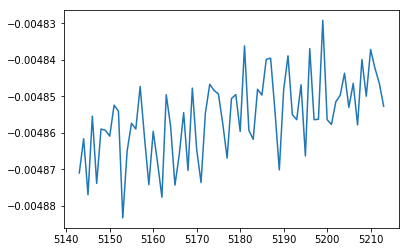

In [307]:
# Check Baselines
column = "116"

baseline = hdf5_file['/raw_data/baselines']
#baseline = baseline[baseline["Filenumber"] == 8979]
plt.plot(baseline["Filenumber"], baseline[column])
plt.show()

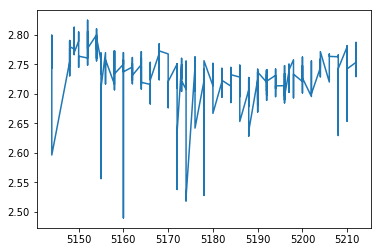

In [308]:
# Check Signals
column = "122"
sample = "NIST 200ppb"

signals = hdf5_file['/raw_data/signals_zero']
signals_sub = signals[signals["Sample"] == sample]
plt.plot(signals_sub["Filenumber"], signals_sub[column])
plt.show()

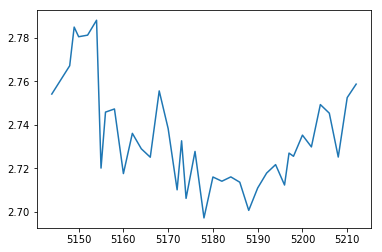

In [309]:
# Check Signals - mean
column = "122"
sample = "NIST 200ppb"

signals = hdf5_file['/raw_data/signals_zero']
signals_mean = df_mean(signals)
signals_sub_mean = signals_mean[signals_mean["Sample"] == sample]
plt.plot(signals_sub_mean["Filenumber"], signals_sub_mean[column])
plt.show()

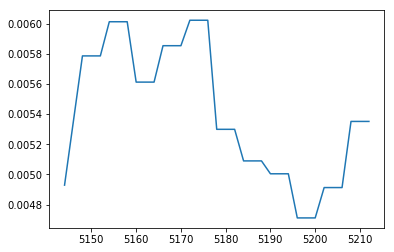

In [310]:
# Check background 
column = "118"
sample = "NIST 200ppb"

background = hdf5_file['/evaluation/bgd_outlier_corr/df_bgd_corr']
background_sub = background[background["Sample"] == sample]
plt.plot(background_sub["Filenumber"], background_sub[column])
plt.show()

In [311]:
background_mean = df_mean(background)

# Outlier rejection

In [368]:
bgd_method = "bgd_outlier_corr"
norm_ratio = "r_122_118"
interf_corr = "Te125_Xe129_corr"

In [369]:
df_all_raw_rat = hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_raw_ratios_af_interf_corr']
df_mean_int_corr = df_mean(hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_amount_interf_corr'])
df_all = hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_internal_norm']

In [374]:
column = "124/118"
sample = "NIST 200ppb"

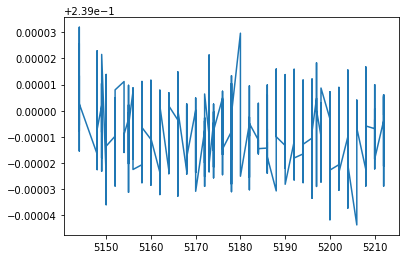

In [375]:
# Check ratios for bracketing standard

df_all_sub = df_all[df_all["Sample"] == sample]
plt.plot(df_all_sub["Filenumber"], df_all_sub[column])
plt.show()

In [376]:
df_outlier_rej_int = df_all.groupby(df_all["Filenumber"]).apply(mad_outlier_rejection)
df_outlier_int = df_all.groupby(df_all["Filenumber"]).apply(mad_outlier)

df_outlier_rej_raw = df_all_raw_rat.groupby(df_all_raw_rat["Filenumber"]).apply(mad_outlier_rejection)
df_outlier_raw = df_all_raw_rat.groupby(df_all_raw_rat["Filenumber"]).apply(mad_outlier)

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in divide
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in divide


In [377]:
df_outlier_rej_int

,Sample,Num_of_Ana_Cyc,Cycle,Filenumber,112/118,114/118,115/118,116/118,117/118,119/118,120/118,122/118,124/118
Date,,,,,,,,,,,,,
2016-11-03 12:07:00,NIST 200ppb,2,1,5144,0.040135,0.027184,0.013938,0.600251,NaN,0.354656,1.345938,NaN,0.239025
2016-11-03 12:07:00,NIST 200ppb,2,2,5144,0.040136,0.027179,0.013941,0.600299,0.316761,0.354663,1.345948,0.19125,0.238994
2016-11-03 12:07:00,NIST 200ppb,2,3,5144,0.040131,0.027174,0.013940,NaN,0.316758,0.354662,1.345926,NaN,0.239004
2016-11-03 12:07:00,NIST 200ppb,2,4,5144,0.040135,0.027170,0.013942,0.600291,0.316761,0.354661,1.345928,0.19125,0.238999
2016-11-03 12:07:00,NIST 200ppb,2,5,5144,0.040136,0.027167,0.013943,0.600263,0.316763,0.354663,1.345975,NaN,0.239013
2016-11-03 12:07:00,NIST 200ppb,2,6,5144,0.040132,0.027171,0.013941,0.600302,0.316751,0.354665,1.345945,0.19125,0.239012
2016-11-03 12:07:00,NIST 200ppb,2,7,5144,0.040140,0.027176,0.013942,0.600289,0.316768,0.354668,1.345941,NaN,0.238992
2016-11-03 12:07:00,NIST 200ppb,2,8,5144,0.040130,0.027169,0.013943,0.600264,NaN,0.354659,1.345954,0.19125,0.239018
2016-11-03 12:07:00,NIST 200ppb,2,9,5144,0.040139,0.027178,0.013945,0.600268,0.316762,0.354652,1.345932,0.19125,0.238996


In [378]:
df_outlier_raw[df_outlier_raw[column].notnull()][column]

Filenumber  Date               
5160        2016-11-03 15:46:00    0.258132
5164        2016-11-03 16:44:00    0.258211
5166        2016-11-03 17:10:00    0.258248
            2016-11-03 17:10:00    0.258242
            2016-11-03 17:10:00    0.258272
5174        2016-11-03 19:02:00    0.258503
            2016-11-03 19:02:00    0.258510
5203        2016-11-04 01:46:00    0.258466
5210        2016-11-04 03:24:00    0.258438
Name: 124/118, dtype: float64

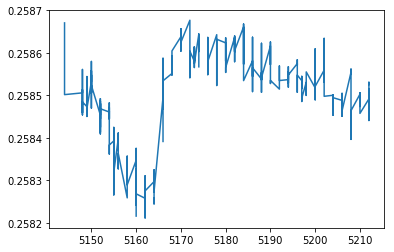

In [379]:
# Check sample measurements
df = df_outlier_rej_raw

df_sub = df[df["Sample"] == sample]
plt.plot(df_sub["Filenumber"], df_sub[column])
plt.show()

In [380]:
df[df["Sample"] == sample][column].std()

0.00010005676047548585

In [381]:
data_mean_int = df_mean(df_outlier_rej_int)
data_mean_int_sd = df_SD(df_outlier_rej_int)

data_mean_raw = df_mean(df_outlier_rej_raw)
data_mean_raw_sd = df_SD(df_outlier_rej_raw)

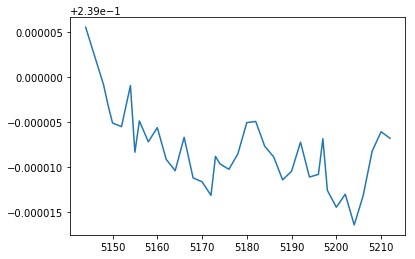

In [382]:
# Check sample measurements
df_mean_used = data_mean_int

df_mean_sub = df_mean_used[df_mean_used["Sample"] == sample]
plt.plot(df_mean_sub["Filenumber"], df_mean_sub[column])
plt.show()

In [383]:
data_mean_int

,Filenumber,Sample,112/118,114/118,115/118,116/118,117/118,119/118,120/118,122/118,124/118
Date,,,,,,,,,,,
2016-11-03 12:07:00,5144,NIST 200ppb,0.040134,0.027172,0.013943,0.600285,0.316764,0.354663,1.345956,0.19125,0.239006
2016-11-03 12:33:00,5146,NIST 350ppb,0.040138,0.027172,0.013946,0.600301,0.316759,0.354657,1.345937,0.19125,0.238999
2016-11-03 12:59:00,5148,NIST 200ppb,0.040137,0.027170,0.013947,0.600310,0.316756,0.354655,1.345979,0.19125,0.238999
2016-11-03 13:13:00,5149,NIST 200ppb,0.040142,0.027174,0.013948,0.600309,0.316751,0.354653,1.345973,0.19125,0.238997
2016-11-03 13:28:00,5150,NIST 200ppb,0.040141,0.027172,0.013947,0.600312,0.316754,0.354654,1.345973,0.19125,0.238995
2016-11-03 13:42:00,5151,NIST 350ppb,0.040141,0.027174,0.013946,0.600318,0.316756,0.354649,1.345937,0.19125,0.238991
2016-11-03 13:57:00,5152,NIST 200ppb,0.040140,0.027173,0.013948,0.600321,0.316757,0.354650,1.345990,0.19125,0.238994
2016-11-03 14:22:00,5154,NIST 200ppb,0.040141,0.027175,0.013947,0.600314,0.316750,0.354650,1.345994,0.19125,0.238999
2016-11-03 14:37:00,5155,NIST 200ppb,0.040140,0.027172,0.013947,0.600318,0.316755,0.354649,1.345985,0.19125,0.238992


In [384]:
date_list = []
                         
data_mean_raw = data_mean_raw.drop(date_list)
data_mean_int = data_mean_int.drop(date_list)
data_mean_raw_sd = data_mean_raw_sd.drop(date_list)
data_mean_int_sd = data_mean_int_sd.drop(date_list)

In [385]:
drop_sum = [pd.Timestamp("2016-11-03 12:07:00"), 
             pd.Timestamp("2016-11-03 12:33:00"), 
             pd.Timestamp("2016-11-03 12:59:00")]

In [386]:

data_mean_int_sum = data_mean_int.drop(drop_sum).groupby("Sample").agg(([np.mean, SD2, 'count']))
data_mean_int_sum = data_mean_int_sum.drop("Filenumber", axis=1)

In [387]:
data_mean_raw_sum = data_mean_raw.drop(drop_sum).groupby("Sample").agg(([np.mean, SD2, 'count']))
data_mean_raw_sum = data_mean_raw_sum.drop("Filenumber", axis=1)

In [388]:
data_mean_int_sum

112/118                   114/118                \
                               mean       SD2 count      mean           SD2   
Sample                                                                        
NIST 200ppb                0.040143  0.000004    36  0.027176  3.829679e-06   
NIST 200ppb + 0.005ppb U   0.040142  0.000003     2  0.027176  3.429624e-07   
NIST 200ppb + 0.015ppb U   0.040144       NaN     1  0.027180           NaN   
NIST 200ppb + 0.030ppb Cd  0.040141  0.000004     2  0.027177  1.667025e-06   
NIST 200ppb + 0.04ppb Cd   0.040144       NaN     1  0.027181           NaN   
NIST 200ppb + 0.100ppb Zr  0.040146       NaN     1  0.027178           NaN   
NIST 200ppb + 0.150ppb Rh  0.040144       NaN     1  0.027176           NaN   
NIST 200ppb + 0.250ppb Pd  0.040141  0.000004     2  0.027177  2.488711e-06   
NIST 200ppb + 0.300ppb Ru  0.040142       NaN     1  0.027175           NaN   
NIST 200ppb + 0.800ppb Mo  0.040142  0.000004     2  0.027177  6.997628e-07   
NIST 200ppb + ME           0.040147       NaN     1  0.027181           NaN   
NIST 350ppb                0.040142  0.000001     4  0.027176  2.934377e-06   

                                  115/118                       116/118  ...   \
                          count      mean           SD2 count      mean  ...    
Sample                                                                   ...    
NIST 200ppb                  36  0.013948  1.482923e-06    36  0.600325  ...    
NIST 200ppb + 0.005ppb U      2  0.013948  2.985636e-06     2  0.600330  ...    
NIST 200ppb + 0.015ppb U      1  0.013948           NaN     1  0.600326  ...    
NIST 200ppb + 0.030ppb Cd     2  0.013947  6.985593e-08     2  0.600328  ...    
NIST 200ppb + 0.04ppb Cd      1  0.013948           NaN     1  0.600327  ...    
NIST 200ppb + 0.100ppb Zr     1  0.013947           NaN     1  0.600327  ...    
NIST 200ppb + 0.150ppb Rh     1  0.013947           NaN     1  0.600320  ...    
NIST 200ppb + 0.250ppb Pd     2  0.013948  3.219947e-06     2  0.600319  ...    
NIST 200ppb + 0.300ppb Ru     1  0.013948           NaN     1  0.600321  ...    
NIST 200ppb + 0.800ppb Mo     2  0.013948  3.146532e-06     2  0.600326  ...    
NIST 200ppb + ME              1  0.013948           NaN     1  0.600329  ...    
NIST 350ppb                   4  0.013947  1.561728e-06     4  0.600321  ...    

                          119/118   120/118                  122/118  \
                            count      mean       SD2 count     mean   
Sample                                                                 
NIST 200ppb                    36  1.345994  0.000016    36  0.19125   
NIST 200ppb + 0.005ppb U        2  1.346009  0.000020     2  0.19125   
NIST 200ppb + 0.015ppb U        1  1.346001       NaN     1  0.19125   
NIST 200ppb + 0.030ppb Cd       2  1.346005  0.000009     2  0.19125   
NIST 200ppb + 0.04ppb Cd        1  1.346000       NaN     1  0.19125   
NIST 200ppb + 0.100ppb Zr       1  1.346002       NaN     1  0.19125   
NIST 200ppb + 0.150ppb Rh       1  1.345997       NaN     1  0.19125   
NIST 200ppb + 0.250ppb Pd       2  1.345999  0.000008     2  0.19125   
NIST 200ppb + 0.300ppb Ru       1  1.345996       NaN     1  0.19125   
NIST 200ppb + 0.800ppb Mo       2  1.345997  0.000004     2  0.19125   
NIST 200ppb + ME                1  1.346006       NaN     1  0.19125   
NIST 350ppb                     4  1.345952  0.000024     4  0.19125   

                                                124/118                  
                                    SD2 count      mean       SD2 count  
Sample                                                                   
NIST 200ppb                1.073945e-16    36  0.238991  0.000007    36  
NIST 200ppb + 0.005ppb U   1.241267e-16     2  0.238993  0.000004     2  
NIST 200ppb + 0.015ppb U            NaN     1  0.238989       NaN     1  
NIST 200ppb + 0.030ppb Cd  1.570092e-16     2  0.238994  0.000002     2  
NIST 200ppb + 0.04ppb Cd   

In [389]:
date_list = []


epsilon_int_200 = SSB(data_mean_int.drop(date_list), "NIST 200ppb", 10000)
delta_raw_200 = SSB(data_mean_raw.drop(date_list), "NIST 200ppb", 1000)

In [390]:
epsilon_int_200

,Filenumber,112/118,114/118,115/118,116/118,117/118,119/118,120/118,122/118,124/118,Sample
Date,,,,,,,,,,,
2016-11-03 12:07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NIST 200ppb
2016-11-03 12:33:00,0.000000,0.676902,0.491572,0.649287,0.063947,-0.030883,-0.064369,-0.231086,2.220446e-12,-0.142937,NIST 350ppb
2016-11-03 12:59:00,2.914602,-0.235661,-0.946172,0.962756,0.214241,-0.041116,-0.091613,0.106917,6.661338e-12,-0.086609,NIST 200ppb
2016-11-03 13:13:00,0.000000,0.771420,1.119011,0.894247,-0.033418,-0.128562,-0.043343,-0.023025,-4.440892e-12,-0.005774,NIST 200ppb
2016-11-03 13:28:00,-0.970780,-0.077088,-0.694444,-0.933097,-0.050025,0.006078,0.075900,-0.064497,2.220446e-12,-0.033008,NIST 200ppb
2016-11-03 13:42:00,0.000000,0.006631,0.503850,-0.708705,0.033709,0.002669,-0.080805,-0.326451,2.220446e-12,-0.139053,NIST 350ppb
2016-11-03 13:57:00,0.000000,-0.101829,-0.012643,0.819851,0.128416,0.155226,-0.055505,0.050692,-1.110223e-12,-0.103941,NIST 200ppb
2016-11-03 14:22:00,0.970214,0.143091,0.765805,-0.286776,-0.090132,-0.193864,0.009573,0.045960,-1.110223e-12,0.250418,NIST 200ppb
2016-11-03 14:37:00,0.000000,-0.705753,-1.973684,0.391032,0.073406,0.100825,0.030670,-0.059652,2.220446e-12,-0.227685,NIST 200ppb


In [391]:

date_list = [pd.Timestamp("2016-11-03 12:33:00"), 
             pd.Timestamp("2016-11-03 12:59:00"),
             pd.Timestamp("2016-11-03 13:13:00")]

epsilon_int_200 = epsilon_int_200.drop(date_list)
delta_raw_200 = delta_raw_200.drop(date_list)

In [392]:
def epsilon_process(df):
    df = df[(df["Filenumber"] >= -20) & (df["Filenumber"] <= 20)]
    df["Filenumber"] = data_mean_int["Filenumber"].ix[df.index]
    return df

In [393]:
epsilon_int_200 = epsilon_process(epsilon_int_200)
delta_raw_200 = epsilon_process(delta_raw_200)

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [394]:
epsilon_int_200

,Filenumber,112/118,114/118,115/118,116/118,117/118,119/118,120/118,122/118,124/118,Sample
Date,,,,,,,,,,,
2016-11-03 13:28:00,5150,-0.077088,-0.694444,-0.933097,-0.050025,0.006078,0.075900,-0.064497,2.220446e-12,-0.033008,NIST 200ppb
2016-11-03 13:42:00,5151,0.006631,0.503850,-0.708705,0.033709,0.002669,-0.080805,-0.326451,2.220446e-12,-0.139053,NIST 350ppb
2016-11-03 13:57:00,5152,-0.101829,-0.012643,0.819851,0.128416,0.155226,-0.055505,0.050692,-1.110223e-12,-0.103941,NIST 200ppb
2016-11-03 14:22:00,5154,0.143091,0.765805,-0.286776,-0.090132,-0.193864,0.009573,0.045960,-1.110223e-12,0.250418,NIST 200ppb
2016-11-03 14:37:00,5155,-0.705753,-1.973684,0.391032,0.073406,0.100825,0.030670,-0.059652,2.220446e-12,-0.227685,NIST 200ppb
2016-11-03 14:51:00,5156,1.132986,2.303612,-1.080283,-0.056230,-0.016396,-0.037268,-0.018779,-1.110223e-12,0.121417,NIST 200ppb
2016-11-03 15:06:00,5157,-0.211376,-0.286245,-0.377375,0.041135,0.045261,-0.066235,-0.384695,-3.330669e-12,-0.178438,NIST 350ppb
2016-11-03 15:20:00,5158,-0.589935,-1.223356,1.091361,-0.014141,0.010605,0.002283,0.095522,2.220446e-12,-0.081716,NIST 200ppb
2016-11-03 15:46:00,5160,-0.161658,0.290679,-0.573244,0.034282,-0.002601,0.019299,-0.085962,0.000000e+00,0.106898,NIST 200ppb


In [395]:
epsilon_int_200_sum = np.round(epsilon_int_200.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
delta_raw_200_sum = np.round(delta_raw_200.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)

epsilon_sum_all = epsilon_int_200_sum
epsilon_sum_all = epsilon_sum_all.drop("Filenumber", axis=1)
delta_raw_sum_all = delta_raw_200_sum
delta_raw_sum_all = delta_raw_sum_all.drop("Filenumber", axis=1)

In [396]:
epsilon_sum_all

112/118              114/118              115/118  \
                             mean    SD2 count    mean    SD2 count    mean   
Sample                                                                        
NIST 200ppb                 0.004  0.780    34   0.006  1.659    34   0.002   
NIST 200ppb + 0.005ppb U    0.008  0.274     2  -0.084  0.333     2   0.203   
NIST 200ppb + 0.015ppb U    0.004    NaN     1   1.243    NaN     1  -0.208   
NIST 200ppb + 0.030ppb Cd  -0.361  0.105     2   0.247  1.114     2  -0.143   
NIST 200ppb + 0.04ppb Cd   -0.217    NaN     1   1.032    NaN     1  -0.462   
NIST 200ppb + 0.100ppb Zr   0.790    NaN     1   0.771    NaN     1  -0.223   
NIST 200ppb + 0.150ppb Rh  -0.142    NaN     1  -0.211    NaN     1  -0.608   
NIST 200ppb + 0.250ppb Pd  -0.169  1.059     2   0.134  2.167     2   0.123   
NIST 200ppb + 0.300ppb Ru  -0.406    NaN     1  -0.586    NaN     1   0.009   
NIST 200ppb + 0.800ppb Mo  -0.094  0.614     2   0.087  0.595     2   0.402   
NIST 200ppb + ME            1.057    NaN     1   2.492    NaN     1   0.373   
NIST 350ppb                -0.282  0.457     4  -0.043  0.965     4  -0.349   

                                       116/118  ...  119/118 120/118         \
                             SD2 count    mean  ...    count    mean    SD2   
Sample                                          ...                           
NIST 200ppb                1.359    34   0.002  ...       34  -0.000  0.087   
NIST 200ppb + 0.005ppb U   1.873     2   0.047  ...        2   0.064  0.038   
NIST 200ppb + 0.015ppb U     NaN     1  -0.031  ...        1   0.067    NaN   
NIST 200ppb + 0.030ppb Cd  0.792     2  -0.003  ...        2   0.060  0.087   
NIST 200ppb + 0.04ppb Cd     NaN     1  -0.057  ...        1   0.029    NaN   
NIST 200ppb + 0.100ppb Zr    NaN     1   0.027  ...        1   0.022    NaN   
NIST 200ppb + 0.150ppb Rh    NaN     1  -0.121  ...        1  -0.036    NaN   
NIST 200ppb + 0.250ppb Pd  1.820     2  -0.073  ...        2   0.023  0.109   
NIST 200ppb + 0.300ppb Ru    NaN     1  -0.112  ...        1  -0.020    NaN   
NIST 200ppb + 0.800ppb Mo  1.841     2   0.014  ...        2   0.019  0.071   
NIST 200ppb + ME             NaN     1   0.023  ...        1   0.026    NaN   
NIST 350ppb                1.115     4  -0.026  ...        4  -0.298  0.148   

                                122/118            124/118               
                          count    mean  SD2 count    mean    SD2 count  
Sample                                                                   
NIST 200ppb                  34     0.0  0.0    34  -0.001  0.216    34  
NIST 200ppb + 0.005ppb U      2     0.0  0.0     2   0.102  0.463     2  
NIST 200ppb + 0.015ppb U      1    -0.0  NaN     1  -0.067    NaN     1  
NIST 200ppb + 0.030ppb Cd     2     0.0  0.0     2   0.083  0.012     2  
NIST 200ppb + 0.04ppb Cd      1    -0.0  NaN     1   0.028    NaN     1  
NIST 200ppb + 0.100ppb Zr     1     0.0  NaN     1   0.058    NaN     1  
NIST 200ppb + 0.150ppb Rh     1     0.0  NaN     1  -0.149    NaN     1  
NIST 200ppb + 0.250ppb Pd     2     0.0  0.0     2   0.063  0.030     2  
NIST 200ppb + 0.300ppb Ru     1     0.0  NaN     1  -0.021    NaN     1  
NIST 200ppb + 0.800ppb Mo     2     0.0  0.0     2   0.034  0.370     2  
NIST 200ppb + ME              1    -0.0  NaN     1   0.157    NaN     1  
NIST 350ppb                   4     0.0  0.0     4  -0.020  0.323     4  

[12 rows x 27 columns]

In [197]:
#hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_int_outlier_corr_all', df_outlier_rej_int, min_itemsize = {"Sample": 50})
#hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_raw_outlier_corr_all', df_outlier_rej_raw, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_mean_int', data_mean_int, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_mean_raw', data_mean_raw, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_epsilon_int', epsilon_int_200, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_delta_raw', delta_raw_200, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method +'/signals_mean', signals_mean, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method +'/background_mean', background_mean, min_itemsize = {"Sample": 50})

NameError: name 'hdf5_sum_file' is not defined

In [ ]:
hdf5_sum_file['/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_epsilon_int']

# Raw data to xls file

In [138]:
signals_raw = hdf5_file['/raw_data/signals_raw']

In [139]:
writer_raw = pd.ExcelWriter(path+'raw_data.xlsx', engine='xlsxwriter')

baseline.to_excel(writer_raw, index=True, sheet_name='baseline')
signals_raw.to_excel(writer_raw, index=True, sheet_name='signals_raw')
signals.to_excel(writer_raw, index=True, sheet_name='signals_baseline_corr')
background.to_excel(writer_raw, index=True, sheet_name='background')

writer_raw.save()

In [397]:
writer_orig = pd.ExcelWriter(path+ bgd_method + '_'  +norm_ratio + '_' + interf_corr +'_old.xlsx', engine='xlsxwriter')


In [398]:
df_mean_int_corr.to_excel(writer_orig, index=True, sheet_name='amount_interf_corr_all')
df_all.to_excel(writer_orig, index=True, sheet_name='data_int_norm_all')
df_all_raw_rat.to_excel(writer_orig, index=True, sheet_name='data_raw_ratios_all')
df_outlier_int.to_excel(writer_orig, index=True, sheet_name='data_int_outliers_all')
data_mean_int_sd.to_excel(writer_orig, index=True, sheet_name='data_mean_int_sd')
data_mean_int_sum.to_excel(writer_orig, index=True, sheet_name='data_mean_int_summary')
data_mean_raw_sd.to_excel(writer_orig, index=True, sheet_name='data_mean_raw_sd')
data_mean_raw_sum.to_excel(writer_orig, index=True, sheet_name='data_mean_raw_summary')
epsilon_int_200.to_excel(writer_orig, index=True, sheet_name='epsilon_int_SSB')
epsilon_sum_all.to_excel(writer_orig, index=True, sheet_name='epsilon_int_SBB_summary')
delta_raw_200.to_excel(writer_orig, index=True, sheet_name='delta_raw_SSB')
delta_raw_sum_all.to_excel(writer_orig, index=True, sheet_name='delta_raw_SBB_summary')

In [399]:
writer_orig.save()

In [230]:
hdf5_sum_file.flush()
hdf5_sum_file.close()

NameError: name 'hdf5_sum_file' is not defined

In [400]:
hdf5_file.flush()
hdf5_file.close()

In [ ]:
# create by plots for selected column
sel_ratio = ["eSn_122_118"]

# defines limits on x-axis
xlim = [-4, 4]

# creates figure
fig = plt.figure(figsize=(10,15))

# iterates over selected ratios and creates plots
for i in range(len(sel_ratio)):
    ax = plt.subplot(5,2,i+1)
    plot_epsilon(sel_ratio[i], "NIST + DS 0.5-0.5", xlim)
fig.tight_layout()
plt.show()
#wb.sheets[4].pictures.add(fig, name= '116/120 norm - bgd_corr 1', update = True)
#fig.savefig(path+"DS_epsilon_x_bgd_122_118_100ppb_mixtures.pdf", bbox_inches='tight')

In [ ]:
# creates a single plot to show mixtures against fspike

std = "NIST + DS 0.5-0.5"
sel_ratio = "eSn_122_118"
sel_var = "fspike"

fig2 = plt.figure(figsize=(10,7))
plt.errorbar(df_DS_inv_mean_sample_sd[df_DS_inv_mean_sample_sd.index.str.contains("NIST")][sel_var]["mean"], epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["mean"] , yerr = epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["SD2"], ls='none', marker="o")
plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
plt.xlim([0, 1])
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
plt.xlabel(sel_var)
plt.show()
#fig2.savefig(path+"DS_epsilon_122_118_fspike_100ppb_mixtures.pdf", bbox_inches='tight')